# WIP: SGD with PyTorch on a subset of MediMNIST dataset

Demonstrate basic concepts behind deep learning using PyTorch low level methods

What we'll learn?

1. Loading data into tensors
1. Idea behind loss function and what we'll use here
1. What is backpropagation
1. Create basic neural net
1. Train that net
1. Assess model performance with accuracy on a test set

### Getting data

Data is freely available on github. On *NIX machine run the code below to get the image files

In [19]:
! git clone https://github.com/apolanco3225/Medical-MNIST-Classification.git
! mv Medical-MNIST-Classification/resized/ ./medical_mnist
! rm -rf Medical-MNIST-Classification

Cloning into 'Medical-MNIST-Classification'...
remote: Enumerating objects: 58532, done.
remote: Total 58532 (delta 0), reused 0 (delta 0), pack-reused 58532
Receiving objects: 100% (58532/58532), 77.86 MiB | 1.83 MiB/s, done.
Resolving deltas: 100% (506/506), done.
Checking connectivity... done.
Checking out files: 100% (58959/58959), done.


### Load necessary libraries

I'll use fastai2 library for convenience here

In [37]:
# run this to install necessary libraries
!pip install fastai2
!pip install torch torchvision

In [24]:
from fastai2.vision.all import *
from utils import *

matplotlib.rc('image', cmap='Greys')

### Load files

We will load only 2 classes here

In [29]:
base_path = Path("medical_mnist/resized")

In medical_mnist/resized/AbdomenCT there are 10000 examples


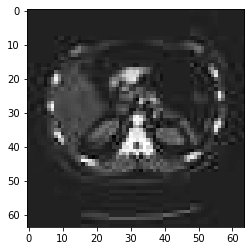

In medical_mnist/resized/BreastMRI there are 8954 examples


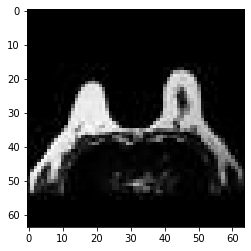

In medical_mnist/resized/CXR there are 10000 examples


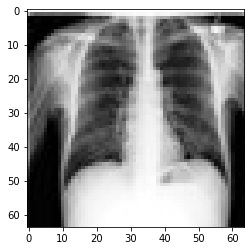

In medical_mnist/resized/ChestCT there are 10000 examples


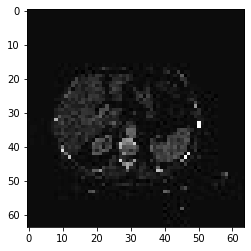

In medical_mnist/resized/Hand there are 10000 examples


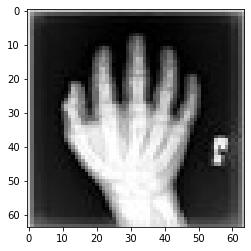

In medical_mnist/resized/HeadCT there are 10000 examples


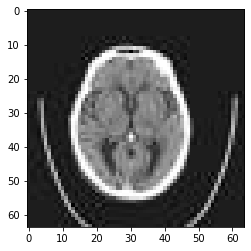

In [61]:
for path in base_path.ls():
    print(f"In {path} there are {len(path.ls())} examples")
    img = Image.open(path.ls()[0])
    plt.imshow(1 - tensor(img).float()/255)
    plt.show()

In [57]:
classes = ['HeadCT', 'Hand']

### Read in images and split into training and validation sets

In [108]:
images = dict()
for cls in classes:
    images[cls] = torch.stack([tensor(Image.open(img_path)).float()/255 for img_path in (base_path/cls).ls()])

In [132]:
train_split = 0.8
train_images = {cls : images_in_cls[:int(len(images_in_cls) * train_split)] for cls, images_in_cls in images.items()}
test_images  = {cls : images_in_cls[:int(len(images_in_cls) * (1-train_split))] for cls, images_in_cls in images.items()}

In [134]:
train_x = torch.cat( (train_images['HeadCT'], train_images['Hand']) ).view(-1, 64*64)
test_x  = torch.cat( (test_images['HeadCT'] , test_images['Hand'] ) ).view(-1, 64*64)

In [141]:
tensor([1]*len(train_images['HeadCT']) + [0]*len(train_images['Hand']))

tensor([1, 1, 1,  ..., 0, 0, 0])

In [147]:
train_y = tensor([1]*len(train_images['HeadCT']) + [0]*len(train_images['Hand'])).unsqueeze(1)
test_y = tensor([1]*len(test_images['HeadCT']) + [0]*len(test_images['Hand'])).unsqueeze(1)

In [148]:
train_dset = list(zip(train_x, train_y))

In [149]:
x, y = train_dset[0]
x.shape, y.shape

(torch.Size([4096]), torch.Size([1]))

### Process for building a model

GRAPH

In [187]:
def initialize_weights(size): 
    return torch.randn(size).requires_grad_()

In [188]:
weights = initialize_weights((64*64, 1))
bias = initialize_weights((1))

In [190]:
def linear_model(X): 
    return X@weights + bias

In [194]:
accuracy = ((linear_model(train_x) > 0) == train_y).float().mean().item()

In [202]:
print(f"Our initial accuracy is: {round(accuracy * 100, 1)}")

Our initial accuracy is: 50.5


Remember that this is before training using just random weights, so however it will vary because of the randomness, it will be usually pretty bad for a start

As the loss function will return values from -∞ to ∞, we need to pass it through sigmoid

In [215]:
def sigmoid(x): 
    return 1/(1+torch.exp(-x))

In [216]:
def loss(predictions, targets):
    predictions = sigmoid(predictions)
    
    return torch.where(targets == 1, 1-predictions, predictions).mean()

In [217]:
loss(linear_model(train_x), train_y)

tensor(0.4943, grad_fn=<MeanBackward0>)

### DataLoader

In [339]:
dset = list(zip(train_x, train_y))
test_dset = list(zip(test_x, test_y))

In [340]:
dl = DataLoader(dset, batch_size=64, shuffle=True)
test_dl = DataLoader(test_dset, batch_size=64, shuffle=True)

In [341]:
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([64, 4096]), torch.Size([64, 1]))

In [342]:
def compute_gradient(X, y, model):
    yh = model(X)
    l = loss(yh, y)
    l.backward()

In [343]:
def train_epoch(model, lr, params):
    for xb, yb in dl:
        compute_gradient(xb, yb, model)
        for p in params:
            p.data -= p.grad * lr
            p.grad.zero_()

In [344]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds > 0.5) == yb
    return correct.float().mean()

In [345]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in test_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [346]:
weights = initialize_weights((64*64, 1))
bias = initialize_weights(1)

In [347]:
lr = 1e-01
params = weights, bias

In [348]:
for i in range(20):
    train_epoch(linear_model, lr, params)
    print(validate_epoch(linear_model), end=" ")

0.7296 0.8806 0.9103 0.9231 0.9287 0.934 0.9368 0.9386 0.9419 0.9434 0.9461 0.9479 0.9468 0.9504 0.9509 0.9516 0.9521 0.9528 0.9551 0.9556 

### Create 2 layer model

and visualize parameters